In [37]:
import sys
import numpy as np
import cv2

import matplotlib.pyplot as plt

(63, 159)


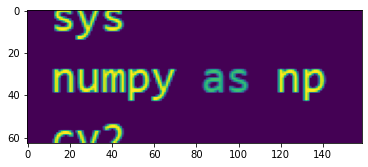

In [38]:
img = cv2.imread('sample.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img)

In [39]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Sequential(
            nn.MaxPool2d(5, 1, padding=2),
            nn.MaxPool2d(3, 1, padding=1),
        )

    def forward(self, x):
        x = x / 255.0
        x = (x > x.mean()).float()
        x = self.filter(x)
        return (x > 0).int()

model = Model()

img = torch.from_numpy(img).unsqueeze_(0)

torch.onnx.export(model, img, 'test.onnx' ,input_names=['x'], output_names=['y'], opset_version=11)

img = model(img)[0].numpy()
img.dtype, img.shape

(dtype('int32'), (63, 159))

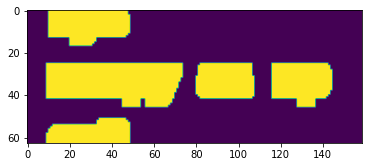

In [40]:
plt.imshow(img)

In [41]:
img = img.astype('uint8')*255

region = []
#  查找轮廓
contours, *_ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
# 利用以上函数可以得到多个轮廓区域，存在一个列表中。
#  筛选那些面积小的
print(len(contours))
for i in range(len(contours)):
    # 遍历所有轮廓
    # cnt是一个点集
    cnt = contours[i]

    # 计算该轮廓的面积
    area = cv2.contourArea(cnt) 

    # 找到最小的矩形，该矩形可能有方向
    rect = cv2.minAreaRect(cnt)
    print (rect)

    # box是四个点的坐标
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # 计算高和宽
    height = abs(box[0][1] - box[2][1])
    width = abs(box[0][0] - box[2][0])

    # 筛选那些太细的矩形，留下扁的
    if(height > width or width < img.shape[1]/16):
        continue

    region.append(box)
    
color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

5
((28.5, 56.5), (11.0, 39.0), 90.0)
((130.0, 35.0), (20.0, 28.0), 90.0)
((93.5, 33.0), (16.0, 27.0), 90.0)
((41.0, 35.0), (20.0, 64.0), 90.0)
((29.0, 8.0), (16.0, 38.0), 90.0)


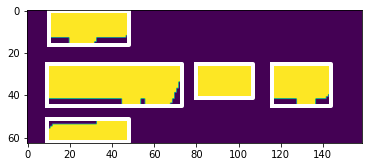

In [42]:
plt.imshow(img)
for box in region:
    # box [4, 2]
    plt.plot(box[:,0], box[:,1], lw=4, c='white')
    plt.plot(box[[0,-1],0], box[[0,-1],1], lw=4, c='white')